In [79]:
%config IPCompleter.greedy=True
#%matplotlib inline
%matplotlib notebook
#%matplotlib widget # for ipympl (needs jupyterlab etc.)

import os, glob
from lammps_multistate_rods.tools.clusters import read_cluster_data

import numpy as np
from scipy.stats import linregress

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

data_dir = '/media/data_ntfs/PhD/simulation stuff/amyloids/data/membrane/wc_1.4/lj_sol_only'

In [80]:
# gets adsorbed data
ads_paths = sorted(glob.glob(os.path.join(data_dir, '*_adsorbed')))
data_points = len(ads_paths)

mem_epss = [0.0]*data_points
int_epss = [0.0]*data_points
timesteps = [None]*data_points
box_dims = [None]*data_points
ads_data = [None]*data_points
avg_ads = [0.0]*data_points
for i in range(data_points):
    params = os.path.basename(ads_paths[i]).split('_')[0]
    mem_epss[i], int_epss[i] = map(float, params.split('-'))
    timesteps[i], box_dims[i], list_ads_IDs = read_cluster_data(ads_paths[i])
    ads_data[i] = [len(ads_IDs) for ads_IDs in list_ads_IDs]
    equi_point = int(0.1*len(timesteps[i]))
    avg_ads[i] = np.average(ads_data[i][equi_point:])

<IPython.core.display.Javascript object>


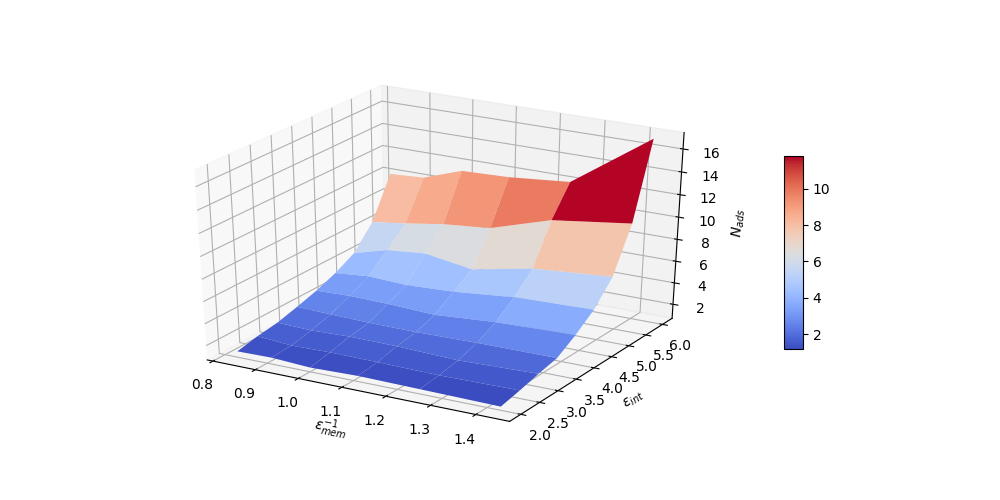

In [81]:
xs = np.unique(mem_epss)
ys = np.unique(int_epss)
x_dim = len(xs)
y_dim = len(ys)
X, Y = np.meshgrid(xs, ys)
Z = np.reshape(avg_ads, (x_dim, y_dim)).transpose()

fig = plt.figure('Membrane adsorption of proteins', figsize=(10,5))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=10)
#ax.scatter3D(mem_epss, int_epss, avg_ads) #as a check of the surf plot
ax.set_xlabel(r'$\epsilon_{mem}^{-1}$')
ax.set_ylabel(r'$\epsilon_{int}$')
ax.set_zlabel(r'$N_{ads}$')
fig.show()

In [82]:
# gets msd data
b_msd_paths = sorted(glob.glob(os.path.join(data_dir, '*_mem_bottom.msd')))
t_msd_paths = sorted(glob.glob(os.path.join(data_dir, '*_mem_top.msd')))
f_msd_paths = sorted(glob.glob(os.path.join(data_dir, '*_mem_full.msd')))
assert data_points == len(b_msd_paths) == len(t_msd_paths) == len(f_msd_paths)

def read_msd_data(filepath):
    timesteps = []
    msds = []
    with open(filepath,'r') as msd_file:
        msd_file.readline(); msd_file.readline()
        for line in msd_file:
            timestep, msd = line.split(' ')
            timesteps.append(int(timestep))
            msds.append(float(msd))
    return timesteps, msds

b_msd_data = [None]*data_points
t_msd_data = [None]*data_points
f_msd_data = [None]*data_points
D_bs = [0.0]*data_points
D_ts = [0.0]*data_points
D_fs = [0.0]*data_points
for i in range(data_points):
    #params = os.path.basename(ads_paths[i]).split('_')[0]
    #test_mem_eps, test_int_eps = map(float, params.split('-'))
    #assert test_mem_eps == mem_epss[i]
    #assert test_int_eps == int_epss[i]
    _, b_msd_data[i] = read_msd_data(b_msd_paths[i])
    _, t_msd_data[i] = read_msd_data(t_msd_paths[i])
    _, f_msd_data[i] = read_msd_data(f_msd_paths[i])
    D_bs[i], b, _, _, sigma = linregress(timesteps[i], b_msd_data[i])
    D_ts[i], b, _, _, sigma = linregress(timesteps[i], t_msd_data[i])
    D_fs[i], b, _, _, sigma = linregress(timesteps[i], f_msd_data[i])

<IPython.core.display.Javascript object>


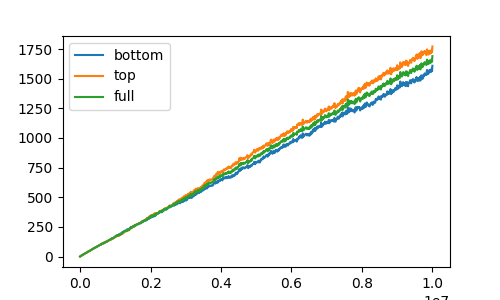

<IPython.core.display.Javascript object>


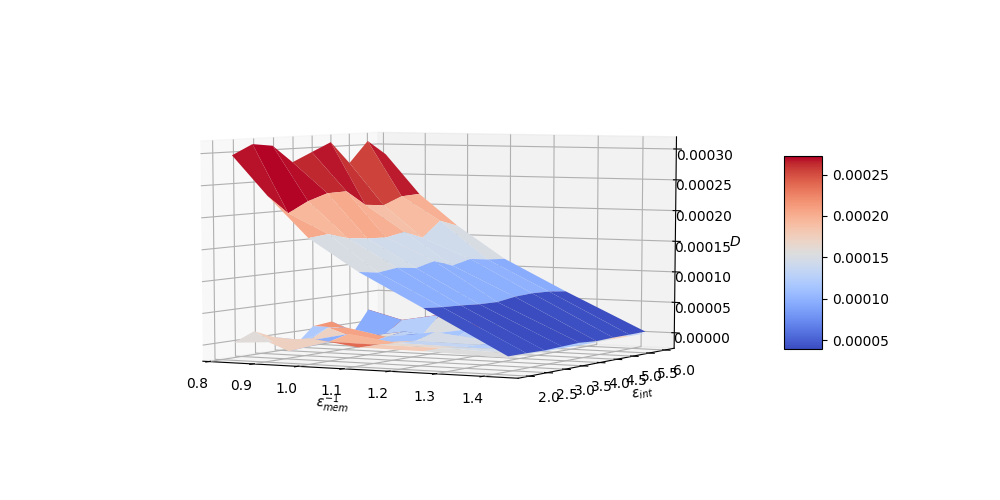

In [83]:
n = 25
fig = plt.figure(r'MSD ({:.2f}, {:.2f})'.format(mem_epss[n], int_epss[n]), figsize=(5,3))
plt.plot(timesteps[n], b_msd_data[n], label='bottom')
plt.plot(timesteps[n], t_msd_data[n], label='top')
plt.plot(timesteps[n], f_msd_data[n], label='full')
plt.legend(loc='upper left')
fig.show()

Z_b = np.reshape(D_bs, (x_dim, y_dim)).transpose()
Z_t = np.reshape(D_ts, (x_dim, y_dim)).transpose()
Z_f = np.reshape(D_fs, (x_dim, y_dim)).transpose()

fig = plt.figure('Lipid diffusion coefficients', figsize=(10,5))
ax = plt.axes(projection='3d')
surf_t = ax.plot_surface(X, Y, Z_t, cmap=cm.coolwarm, label='top')
surf_diff = ax.plot_surface(X, Y, Z_t-Z_b, cmap=cm.coolwarm, label='diff')
plt.colorbar(surf_t, shrink=0.5, aspect=5)
ax.set_xlabel(r'$\epsilon_{mem}^{-1}$')
ax.set_ylabel(r'$\epsilon_{int}$')
ax.set_zlabel(r'$D$')
#plt.legend()
fig.show()